# Gantry spherical scan

Author: Blair Jamieson\
Date: December 2023\
Modified: June by Hamish J (P-ONE)

## Gantry coordinates.

The long axis of the gantry is $x$, the other horizontal axis is $y$, and the vertical axis is $z'$.  Note that the gantry motion in $x$ and $y$ are correct, while the motion in $z$ starts at $z=z'=0$ and as the gantry $z'$ coordinate is increased $z=-z'$.

The end of the gantry's $xyz$ motion is at $\vec{r}_g$ and the location of the calibration target $\vec{r}_t'$ relative to that position depends on the rotation in the $xy$-plane $\phi_g$, and the rotation relative to the $z$ axis $\theta_g$.

$$ \vec{r}_t' = 25\ \rm{cm}\ ( \sin{\phi_g} \hat{i} + \cos{\phi_g} \hat{j} ) $$

The location of the target in gantry coordinates is:

$$ \vec{r}_t = \vec{r}_g + \vec{r}_t' $$

$$ \vec{r}_t = (x_g + 25\ \rm{cm}\ \sin{\phi_g})\hat{i} + (y_g + 25\ \rm{cm}\  \cos{\phi_g})\hat{j} - z_g'\hat{k}$$

The pointing of the calibration target (normal to the checkerboard pattern) is $\hat{n}_t$.  Note that the angle $\theta_g$ is the true spherical coordinates angle from the $z$-axis, but $\phi_g$ is measured going positive going counter-clockwise from the $y$-axis.  Therefore the true spherical coordinate $\phi = 90^{\circ} - \phi_g$.  The normal to the calibration target is:

$$\hat{n}_t = \sin{\theta_g}\cos{\phi_g}\hat{i} - \sin{\theta_g}\sin{\phi_g}\hat{j} + \cos{\theta_g}\hat{k}$$

In the gantry coordinates we define the camera position $\vec{r}_c$ and its facing $\hat{n}_c$.

## Scan semi-sphere around camera

Suppose we want to scan a semi-spherical plane around the camera.  How do we equally space the points on the surface of the sphere?  See for example https://www.cmu.edu/biolphys/deserno/pdf/sphere_equi.pdf

The basic idea is to keep the solid angle between points constant, where

$$dA = r^2 \sin{\theta} d\theta d\phi= r d(r\cos{\theta}) d\phi = rdzd\phi$$

Choose circles of latitude at constant intervals $d_{\theta}$, and on each circle space points by distance $d_{\phi}$ such that $d_{\theta}\sim d_{\phi}$.  Suppose we want $N$ points in total.  Then:

```
dA = 4 * pi / N # as solid angle
d = sqrt( dA )
Mtheta = round( pi / d )
dtheta = pi / Mtheta
dphi = dA / dtheta
for m in range(Mtheta):
    theta = pi * ( m + 0.5 ) * m / Mtheta
    Mphi = round( 2*pi*sin(theta) / d_theta )
    for n in range(Mphi):
        phi = 2 * pi * n / Mphi
        rcvec = r * [ sin( theta )*cos(phi), 
                       sin( theta )*sin(phi),
                       cos( theta ) ]
```

Now lets consider that we don't want to scan a full sphere, since we are limited to some range of coordinates in the gantry.  Instead, lets pick a number of scan points $N$ as before, and then start and end points in $\theta$ and $\phi$.  Eg. five parameters for the scan are specified: $(N,\theta_{1},\theta_{2}, \phi_{1}, \phi_{2})$, where the ranges are chosen to allow the points in the scan to be possible for the gantry to accomplish.  

The cross sectional area covered is no longer $4\pi$, but is:

$$ dA = \Delta \phi ( \cos{ \theta_{1} } - \cos{ \theta_{2}} )$$
$$\Delta \phi = \phi_{2} - \phi_{1}$$

The updated code becomes:

```
dA = (phi2-phi1) * ( cos(theta1) - cos(theta2) ) / N
d = sqrt( dA )
Mtheta = round( (theta2 - theta1) / d )
dtheta = (theta2 - theta1) / Mtheta
dphi = dA / dtheta
for m in range(Mtheta):
    theta = theta1 + (theta2-theta1) * ( m + 0.5 ) * m / Mtheta
    Mphi = round( (phi2-phi1)*sin(theta) / d_theta )
    for n in range(Mphi):
        phi = phi1 +  (phi2-phi1) * n / Mphi
        rcvec = rc * [ sin( theta )*cos(phi), 
                       sin( theat )*sin(phi),
                       cos( theta ) ]
```


## Rotate from camera coords to gantry coords

In the camera coordinates, define the scan point a distance $r$ from the camera as $\vec{r'}$, and in gantry coordinates the normal to the camera as $\hat{n}$.  To keep things simple, lets assume the camera coordinate $z$-axis is the same as the gantry coordinate $z$-axis, then the rotation is just in the plane. ie. $\vec{n}$.  The angle $\phi'$ in the gantry coordinates then depends on the angle $\phi'$ between the normal and the gantry x-axis:

$$ \phi' = {\rm arctan2}{( n_y, n_x )}$$



In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from gantry_spherical_scan import camera
from gantry_spherical_scan import get_gantry_settings
from parameters import ParametersSphere  # Overwritten Parameters class designed for sphere scan
import time

from pathlib import Path  # For creating dir for plots and parameters file

In [13]:
# Helpers
deg2rad   = np.pi/180.0
rad2deg   = 180.0/np.pi

# %--------------------------------% #
# %----- USER PARAMETERS HERE -----% # Set these parameters then run all
# %--------------------------------% # Generates nice plots and parameters.txt
Nscan     = 10
Rscan     = 450.0 # mm, hemisphere is 17in in diamete -> radius of 21.6 cm
#campos    = [900.0, 830.0, -730.0] #mm
campos = [900.0, 580.0, -730.0] #mm
camfacing = [0.0, -220, 0.0]  # diffuser centered ~220mm from back of delrin plate
phimin    = -90 * deg2rad
phimax    = (0) * deg2rad
thetamin  = (90-2) * deg2rad
thetamax  = (90+2) * deg2rad
# %--------------------------------% #
# %--------------------------------% #
# %--------------------------------% #

# Generate a parameters object to easily save the file to be read later
parameters = ParametersSphere("spherical_scans/blank_parameters.txt")
parameters.Nscan = Nscan
parameters.Rscan = Rscan
parameters.campos = campos
parameters.camfacing = camfacing
parameters.phimin = phimin
parameters.phimax = phimax
parameters.thetamin = thetamin
parameters.thetamax = thetamax

# initalize camera object
c1 = camera( campos, camfacing )
# generate camera scan points
scanpts = c1.get_scanpoints(N=Nscan,r=Rscan, 
                            phi1=phimin, phi2=phimax,
                            theta1=thetamin, theta2=thetamax)
npscanpts=np.array(scanpts)

# Code to safe parameters file and plots to its own file
identifier = f'phi,{phimin*rad2deg:.2f},{phimax*rad2deg:.2f}_theta,{thetamin*rad2deg:.2f},{thetamax*rad2deg:.2f}_campos,{','.join([str(_) for _ in campos])}_N,{Nscan}'
plot_folder = f'spherical_scans/{identifier}/'
Path(plot_folder).mkdir(parents=True, exist_ok=True)  # Make dir if it doesnt exist
time.sleep(0.5)  # wait half a second to create the directory
# save parameters
print(plot_folder + "parameters.txt")
parameters.export_parameters(plot_folder + "parameters.txt")

camera phi= -1.5707963267948966
spherical_scans/phi,-90.00,0.00_theta,88.00,92.00_campos,900.0,580.0,-730.0_N,10/parameters.txt
Nscan     = 10
Rscan     = 450.0 mm
campos    = 900.0, 580.0, -730.0 mm
camfacing = 0.0, -220, 0.0 mm
phimin    = -90.00000 deg
phimax    = 0.00000 deg
thetamin  = 88.00000 deg
thetamax  = 92.00000 deg


## Visualize the chosen scan points and target

[0, -399.7563308076383, 13.959798681000432] 1.53588974175501
[0, -399.7563308076383, -13.959798681000382] 1.6057029118347832


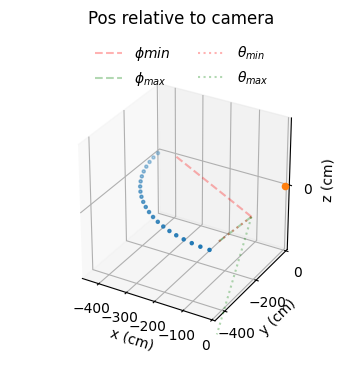

[2.7554552980815446e-14, 2.7554552980815446e-14]


In [15]:
X=npscanpts.T[0]
Y=npscanpts.T[1]
Z=npscanpts.T[2]
fig=plt.figure(figsize=np.array([3.3, 3.3])*1.35, dpi=100)  # type: ignore
ax = fig.add_subplot(projection='3d')
ax.set_box_aspect(aspect=[1,1.,1.], zoom=0.75)  # type: ignore

# Data
ax.scatter(X,Y,Z,marker='.')
ax.scatter(0.,0.,0.,'o')

# Draw lines for data cutoffs
l1 = [camfacing, [400*np.sin(phimin), -400*np.cos(phimin), 0], 'r', r'$\phi{min}$']  # phimin
l2 = [camfacing, [400*np.sin(phimax), -400*np.cos(phimax), 0], 'g', r'$\phi_{max}$']  # phimax
for r0, r1, c, l in [l1, l2,]:
    x_0, y_0, z_0 = r0
    x_1, y_1, z_1 = r1
    x_1 = np.min([x_1, np.max(X)])
    y_1 = np.max([y_1, np.min(Y)])
    z_1 = np.min([z_1, np.max(Z)])
    ax.plot((x_0, x_1), (y_0, y_1), (z_0, z_1), color=c, linestyle='dashed', alpha = 0.3, label=l)

l1 = [camfacing, [0, -400*np.sin(thetamin), 400*np.cos(thetamin)], 'r', r'$\theta_{min}$']  # thetamin
l2 = [camfacing, [0, -400*np.sin(thetamax), 400*np.cos(thetamax)], 'g', r'$\theta_{max}$']  # thetamax
print(l1[1], thetamin)
print(l2[1], thetamax)
for r0, r1, c, l in [l1, l2,]:
    x_0, y_0, z_0 = r0
    x_1, y_1, z_1 = r1
    x_1 = np.min([x_1, np.max(X)])
    y_1 = np.max([y_1, np.min(Y)])
    z_1 = np.min([z_1, np.max(Z)])
    ax.plot((x_0, x_1), (y_0, y_1), (z_0, z_1), color=c, linestyle='dotted', alpha = 0.3, label=l)

# Formatting
ax.set_xlabel('x (cm)')
ax.set_ylabel('y (cm)')
ax.set_zlabel('z (cm)')  # type: ignore
bounds_pad = 10
ax.set(yticks=[-400, -200, 0], zticks=[0, 200, 400],
       xlim=[np.min([np.min(X), 0])-bounds_pad, np.max([np.max(X), 0])+bounds_pad],
       ylim=[np.min([np.min(Y), 0])-bounds_pad, np.max([np.max(Y), 0])+bounds_pad],
       zlim=[np.min([np.min(Z), 0])-bounds_pad, np.max([np.max(Z), 0])+bounds_pad])
plt.title('Pos relative to camera',)
plt.legend(framealpha=0, ncols=2, loc=9)
plt.savefig(plot_folder+'pos_rel_camera.png', dpi=300, bbox_inches='tight')
plt.show()
print([np.min(np.min(Z), 0), np.max(np.max(Z), 0)])

Text(0.5, 1.0, 'Pos relative to camera')

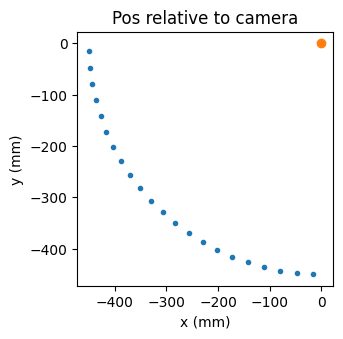

In [16]:
plt.figure(figsize=(3.3,3.3),dpi=100)
plt.plot(X,Y,'.')
plt.xlabel('x (mm)')
plt.ylabel('y (mm)')
plt.plot(0.,0.,'o')
plt.title('Pos relative to camera')

Text(0.5, 1.0, 'Pos relative to camera')

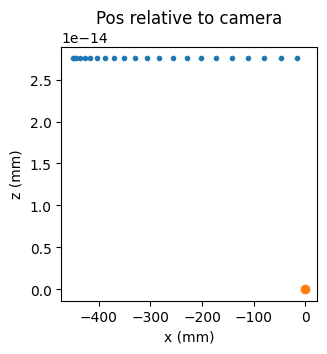

In [17]:
plt.figure(figsize=(3.3,3.3),dpi=100)
plt.plot(X,Z,'.')
plt.xlabel('x (mm)')
plt.ylabel('z (mm)')
plt.plot(0.,0.,'o')
plt.title('Pos relative to camera')

Text(0.5, 1.0, 'Pos relative to camera')

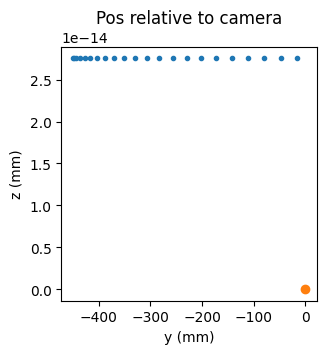

In [18]:
plt.figure(figsize=(3.3,3.3),dpi=100)
plt.plot(Y,Z,'.')
plt.xlabel('y (mm)')
plt.ylabel('z (mm)')
plt.plot(0.,0.,'o')
plt.title('Pos relative to camera')

## Now calculate position and rotation of gantry

Now that we have a list of camera vectors $\vec{r}$ in gantry coordinates, we want to calculate the vector $\vec{r}_g$, $\theta_g$, and $\phi_g$ (the x,y,z of the gantry and its rotation).  This position is such that:

$$\vec{r}_g+\vec{r}_t = \vec{r}_c + \vec{r}$$

$$\vec{r}_g = \vec{r}_c + \vec{r} - \vec{r}_t$$

The vector $\vec{r}$ and $\vec{r}_c$ we get from the camera.  The vector $\vec{r}_t$ depends on the normal vector of $-\vec{r}$ (the target facing $\hat{n_t}$).  We find:

$$ \hat{n_t} = -\frac{\vec{r}}{r} $$
$$ \phi = \rm{arctan2}( n[1] , n[0] )$$
$$ \theta = \rm{arctan2}\left( \frac{n[2]}{\sqrt{n[0]^2+n[1]^2} } \right)$$

The gantry facing is then $\phi_g=\phi$ and $\theta_g=\theta$.  The gantry target vector is:

$$ \vec{r}_t' = 25\ \rm{cm}\ ( -\sin{\phi_g} \hat{i} + \cos{\phi_g} \hat{j} ) $$



In [19]:
# Initialize gantry parameters from camera object
gsets, tls = get_gantry_settings( c1, scanpts )

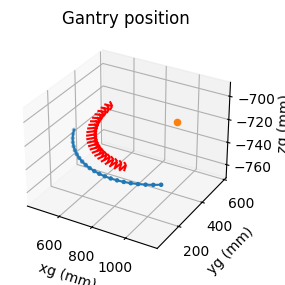

In [20]:

npgsets = np.array(gsets)  # list of gantry settings
GX = npgsets.T[0]  # cm
GY = npgsets.T[1]  # cm
GZ = npgsets.T[2]  # cm
Gphi = npgsets.T[3]  # rad
Gtheta = npgsets.T[4]  # rad

nptls = np.array(tls)  # list of target positions
TX = nptls.T[0]  # cm
TY = nptls.T[1]  # cm
TZ = nptls.T[2]  # cm

NX = nptls.T[3]  # normalized
NY = nptls.T[4]  # normalized
NZ = nptls.T[5]  # normalized

fig=plt.figure(figsize=(3,3),dpi=100)
ax = fig.add_subplot(projection='3d')
ax.plot(GX,GY,GZ)
ax.scatter(GX,GY,GZ,marker='.')
ax.scatter( c1.rc[0], c1.rc[1], c1.rc[2], marker='o')

ax.quiver(GX+TX,GY+TY,GZ+TZ,NX,NY,NZ,length=50.0,color='r')
ax.set_xlabel('xg (mm)')
ax.set_ylabel('yg (mm)')
ax.set_zlabel('zg (mm)')
ax.set_title('Gantry position')
plt.savefig(plot_folder+'gantry_position.png', dpi=300, bbox_inches='tight')
#plt.savefig()

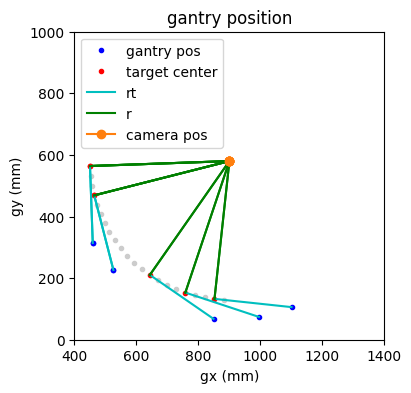

In [21]:
# Visualize from above with some points shown in detail
plt.figure(figsize=(4,4),dpi=100)

plt.plot( GX+TX, GY+TY, '.',color='0.8')
ptnum=0
plt.plot( GX[ptnum], GY[ptnum],'.',color='b',label='gantry pos')
#plt.plot( [0.,GX[ptnum]], [0.,GY[ptnum]], color='k',label='rg')
plt.plot(GX[ptnum]+TX[ptnum],GY[ptnum]+TY[ptnum],'.',color='r',label='target center')
plt.plot( [GX[ptnum],GX[ptnum]+TX[ptnum]], [GY[ptnum],GY[ptnum]+TY[ptnum]], color='c', label='rt')
plt.plot( [GX[ptnum]+TX[ptnum], c1.rc[0]], [ GY[ptnum]+TY[ptnum], c1.rc[1]], color='g')
plt.plot( [c1.rc[0],c1.rc[0]+X[ptnum]], [c1.rc[1],c1.rc[1]+Y[ptnum]], color='g', label='r')
plt.plot( c1.rc[0], c1.rc[1], marker='o', color='C1', label='camera pos')

n_sample_points = 6
np.random.seed(44)
for ptnum in np.random.choice(np.size(GX), size=n_sample_points):
    plt.plot( GX[ptnum], GY[ptnum],'.',color='b')
    #plt.plot( [0.,GX[ptnum]], [0.,GY[ptnum]], color='k')
    plt.plot(GX[ptnum]+TX[ptnum],GY[ptnum]+TY[ptnum],'.',color='r')
    plt.plot( [GX[ptnum],GX[ptnum]+TX[ptnum]], [GY[ptnum],GY[ptnum]+TY[ptnum]], color='c')
    plt.plot( [GX[ptnum]+TX[ptnum], c1.rc[0]], [ GY[ptnum]+TY[ptnum], c1.rc[1]], color='g')
    plt.plot( [c1.rc[0],c1.rc[0]+X[ptnum]], [c1.rc[1],c1.rc[1]+Y[ptnum]], color='g')
    plt.plot(c1.rc[0], c1.rc[1], marker='o', color='C1')
plt.xlabel('gx (mm)')
plt.ylabel('gy (mm)')
plt.title('gantry position')
plt.xlim([400,1400])
plt.ylim([0,1000])

plt.legend(loc='upper left')
plt.savefig(plot_folder+'gantry_arm_samples.png', dpi=300, bbox_inches='tight')

Text(0.5, 1.0, 'gantry position')

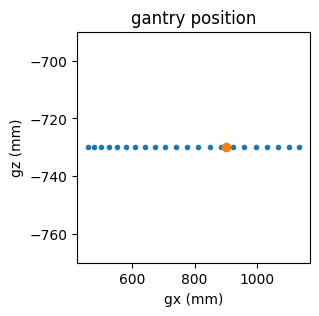

In [22]:
plt.figure(figsize=(3,3),dpi=100)
plt.plot(GX,GZ,'.')
plt.plot( c1.rc[0], c1.rc[2],  marker='o')
plt.xlabel('gx (mm)')
plt.ylabel('gz (mm)')
plt.title('gantry position')

Text(0.5, 1.0, 'gantry position')

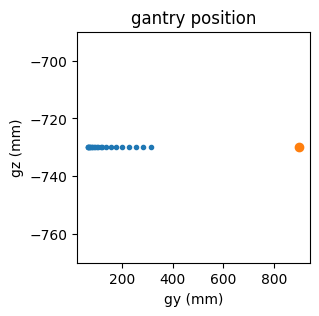

In [23]:
plt.figure(figsize=(3,3),dpi=100)
plt.plot(GY,GZ,'.')
plt.plot( c1.rc[0], c1.rc[2],  marker='o')
plt.xlabel('gy (mm)')
plt.ylabel('gz (mm)')
plt.title('gantry position')

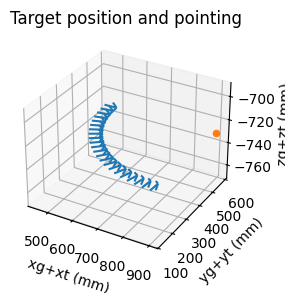

In [24]:


fig=plt.figure(figsize=(3,3),dpi=100)
ax = fig.add_subplot(projection='3d')
ax.quiver(GX+TX,GY+TY,GZ+TZ,NX,NY,NZ,length=50.0)
ax.scatter( c1.rc[0], c1.rc[1], c1.rc[2], marker='o', color='C1')

ax.set_xlabel('xg+xt (mm)')
ax.set_ylabel('yg+yt (mm)')
ax.set_zlabel('zg+zt (mm)')
ax.set_title('Target position and pointing')
plt.savefig(plot_folder+'target_pointing.png', dpi=300, bbox_inches='tight')

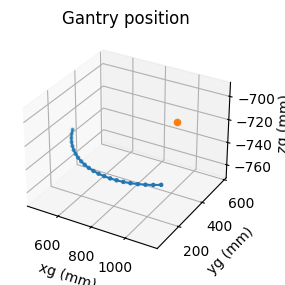

In [25]:

fig=plt.figure(figsize=(3,3),dpi=100)
ax = fig.add_subplot(projection='3d')
ax.plot(GX,GY,GZ)
ax.scatter(GX,GY,GZ,marker='.')
ax.scatter( c1.rc[0], c1.rc[1], c1.rc[2], marker='o', color='C1')
ax.set_xlabel('xg (mm)')
ax.set_ylabel('yg (mm)')
ax.set_zlabel('zg (mm)')
ax.set_title('Gantry position')
plt.savefig(plot_folder+'gantry_path.png', dpi=300, bbox_inches='tight')

Text(0.5, 1.0, 'target position')

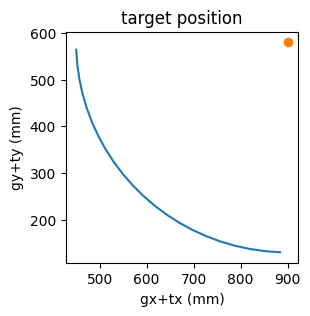

In [26]:
plt.figure(figsize=(3,3),dpi=100)
plt.plot(GX+TX,GY+TY)
plt.plot( c1.rc[0], c1.rc[1],  marker='o', color='C1')
plt.xlabel('gx+tx (mm)')
plt.ylabel('gy+ty (mm)')
plt.title('target position')

Text(0.5, 1.0, 'target position')

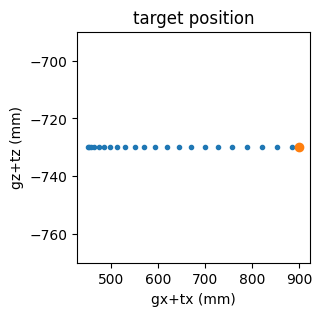

In [27]:
plt.figure(figsize=(3,3),dpi=100)
plt.plot(GX+TX,GZ+TZ,'.')
#plt.plot(GX,GZ,'.')
plt.plot( c1.rc[0], c1.rc[2],  marker='o', color='C1')
plt.xlabel('gx+tx (mm)')
plt.ylabel('gz+tz (mm)')
plt.title('target position')

In [24]:
# actual number of scan points?
print('N scan points =',len(X))

N scan points = 117


In [25]:
from tabulate import tabulate
print()
print(tabulate( np.concatenate( (npgsets , nptls),axis=1) ,\
               headers=['xg','yg','zg','phig','thetag','xt','yt','zt','ntx','nty','ntz'],\
               floatfmt=['.1f','.1f','.1f','.3f','.3f','.1f','.1f','.1f','.3f','.3f','.3f' ] ))


    xg     yg      zg    phig    thetag      xt      yt    zt     ntx    nty     ntz
------  -----  ------  ------  --------  ------  ------  ----  ------  -----  ------
1170.6  193.7  -523.8   1.623    -0.476  -249.7   -13.1   0.0  -0.047  0.888  -0.458
1209.5  224.1  -523.8   1.728    -0.476  -246.9   -39.1   0.0  -0.139  0.878  -0.458
1245.0  258.4  -523.8   1.833    -0.476  -241.5   -64.7   0.0  -0.230  0.859  -0.458
1276.7  296.2  -523.8   1.937    -0.476  -233.4   -89.6   0.0  -0.319  0.830  -0.458
1304.3  337.1  -523.8   2.042    -0.476  -222.8  -113.5   0.0  -0.404  0.792  -0.458
1327.5  380.7  -523.8   2.147    -0.476  -209.7  -136.2   0.0  -0.484  0.745  -0.458
1346.0  426.5  -523.8   2.251    -0.476  -194.3  -157.3   0.0  -0.559  0.691  -0.458
1359.6  474.0  -523.8   2.356    -0.476  -176.8  -176.8   0.0  -0.629  0.629  -0.458
1368.2  522.6  -523.8   2.461    -0.476  -157.3  -194.3   0.0  -0.691  0.559  -0.458
1371.6  571.8  -523.8   2.566    -0.476  -136.2  -209.7   0.0  -

In [26]:
rad2deg   = 180.0/np.pi
print('Minimum tgt x = ',np.min( GX+TX ),'mm')
print('Maximum tgt x = ',np.max( GX+TX ),'mm')
print('Minimum tgt y = ',np.min( GY+TY ),'mm')
print('Maximum tgt y = ',np.max( GY+TY ),'mm')
print('Minimum tgt z = ',np.min( GZ+TZ ),'mm')
print('Maximum tgt z = ',np.max( GZ+TZ ),'mm')
print('Minimum gtry x = ',np.min( GX ),'mm')
print('Maximum gtry x = ',np.max( GX ),'mm')
print('Minimum gtry y = ',np.min( GY ),'mm')
print('Maximum gtry y = ',np.max( GY ),'mm')
print('Minimum gtry z = ',np.min( GZ ),'mm')
print('Maximum gtry  z = ',np.max( GZ ),'mm')
print('Minimum phi=',np.min( Gphi )*rad2deg,'deg')
print('Maximum phi=',np.max( Gphi )*rad2deg,'deg')
print('Minim theta=',np.min( Gtheta )*rad2deg,'deg')
print('Maxim theta=',np.max( Gtheta )*rad2deg,'deg')

Minimum tgt x =  920.5445312567988 mm
Maximum tgt x =  1278.5640897740313 mm
Minimum tgt y =  130.50969736764642 mm
Maximum tgt y =  362.1574835308452 mm
Minimum tgt z =  -936.2019347773346 mm
Maximum tgt z =  -523.7980652226653 mm
Minimum gtry x =  1170.2613660525508 mm
Maximum gtry x =  1413.7242941379309 mm
Minimum gtry y =  142.40517632358197 mm
Maximum gtry y =  571.8251255172012 mm
Minimum gtry z =  -936.2019347773346 mm
Maximum gtry  z =  -523.7980652226653 mm
Minimum phi= 92.72727272727273 deg
Maximum phi= 147.27272727272728 deg
Minim theta= -27.272727272727277 deg
Maxim theta= 27.27272727272727 deg


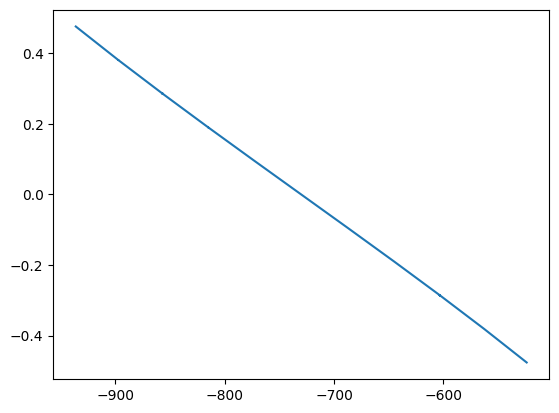

In [27]:
plt.plot( GZ, Gtheta )

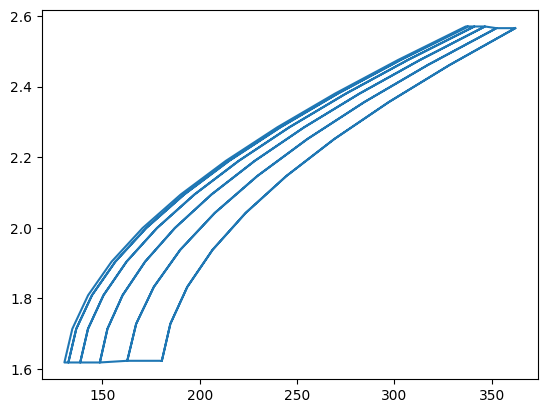

In [28]:
plt.plot( GY+TY, Gphi )